<a href="https://colab.research.google.com/github/dipayandas97/Deep-Learning-Notebooks/blob/master/Animal_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-f8bku1q5
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-f8bku1q5
  Created wheel for tensorflow-examples: filename=tensorflow_examples-b88cccc17e58281b8881feb0b9fb0385b8017e24_-cp37-none-any.whl size=270921 sha256=84f418e035ce20786c8dfb2af3b7691c66a7e4bab841b544c94ea50453712855
  Stored in directory: /tmp/pip-ephem-wheel-cache-4inayoyw/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#DATASET Preparation


##Import dataset

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteH45Q6L/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteH45Q6L/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [51]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

##Transforms

In [56]:
def normalize(input_image, input_mask=None):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    if input_mask is not None:
        input_mask -= 1
        return input_image, input_mask
    else:
        return input_image

In [5]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

    #Random horz. flipping
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask        

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask        

##Initialize datasets

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 6
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)


##Display(image, true_mask, pred_mask)

In [21]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1,len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
for image, mask in train.take(1):
    display([image, mask])

#Model

##Encoder

In [7]:
#Encoder: pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

#Outputs from intermediate layers
output_layer_names = [
                      'block_1_expand_relu',  # 64X64
                      'block_3_expand_relu',  # 32x32
                      'block_6_expand_relu',  # 16x16
                      'block_13_expand_relu', # 8x8
                      'block_16_project',     # 4x4 
                      ]
base_model_outputs = [base_model.get_layer(name).output for name in output_layer_names]

#Create model
encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
encoder.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#tf.keras.utils.plot_model(encoder, to_file='encoder.png')
encoder.summary()

##Decoder

In [37]:
from tensorflow_examples.models.pix2pix import pix2pix

#Decoder layers
decoder_layers = [ pix2pix.upsample(512,3, apply_dropout=True),    # 4x4 -> 8x8
            pix2pix.upsample(256,3, apply_dropout=True),    # 8x8 -> 16x16
            pix2pix.upsample(128,3, apply_dropout=True),    # 16x16 -> 32x32
            pix2pix.upsample(64,3, apply_dropout=True),    # 32x32x -> 64x64
          ]

In [38]:
#Define U-NET model
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128,3])

    #encode
    skip_connection_outputs = encoder(inputs)
    x = skip_connection_outputs[-1] #last output layer
    skip_connection_outputs = reversed(skip_connection_outputs[:-1])    #access deeper outputs first

    #decode
    for decode, skip_connection_output in zip(decoder_layers, skip_connection_outputs):
        x = decode(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x,skip_connection_output])
    
    #final layer
    last = tf.keras.layers.Conv2DTranspose(
                                           filters=output_channels, kernel_size=3, strides=2,
                                           padding='same'
                                          )     #64x64 -> 128x128
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


#Compile & Train

In [39]:
OUTPUT_CHANNELS = 3
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

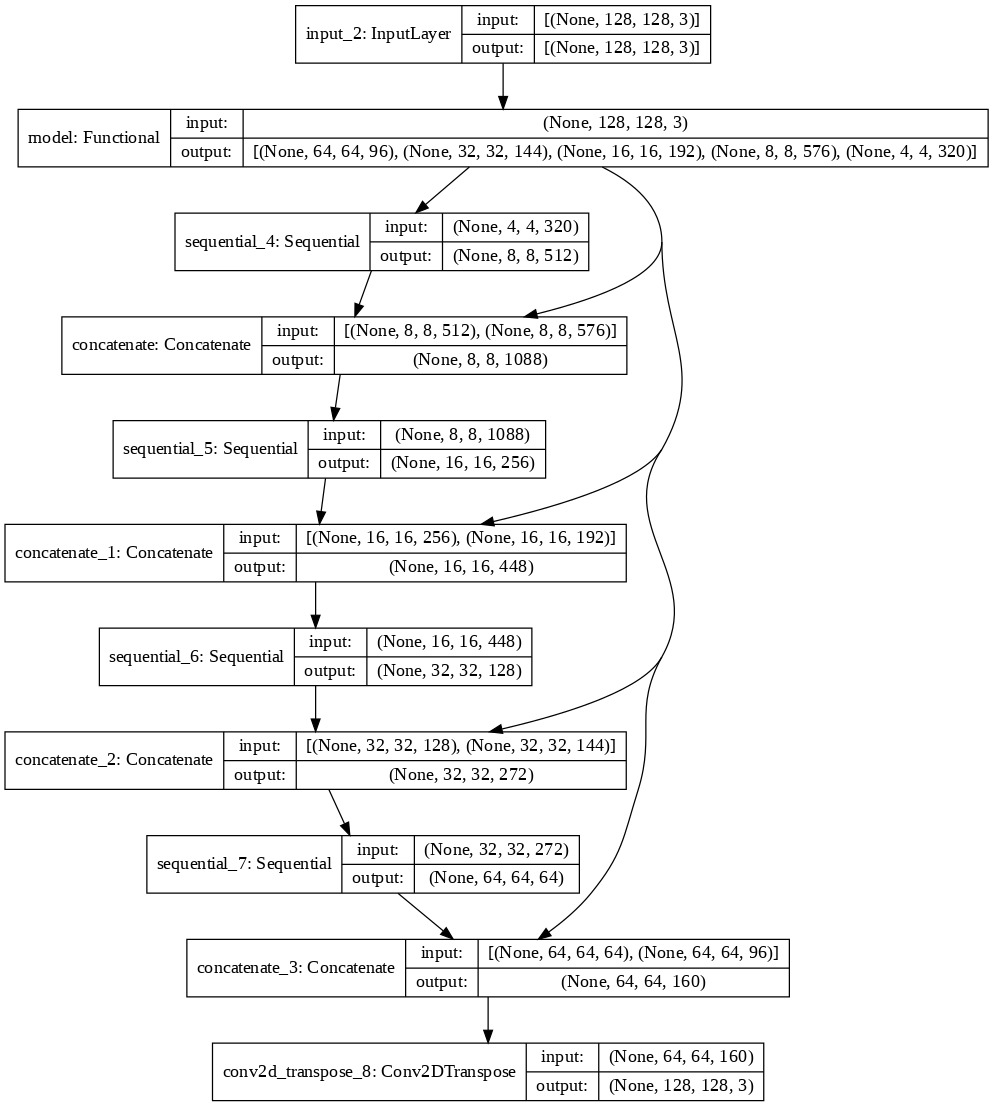

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=90)


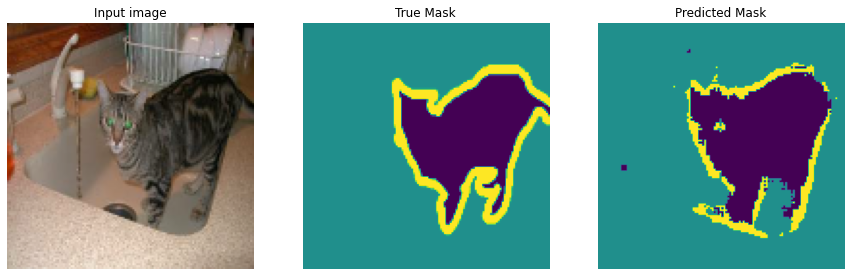

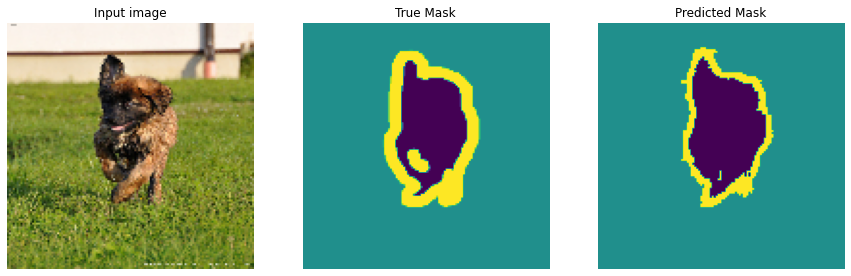

In [49]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

def show_predictions(image=None, mask=None, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(1):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask[0])])
    elif image is not None:
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask[0])])

show_predictions(dataset=train_dataset)  
show_predictions(dataset=test_dataset)  

In [23]:
#Callback function to visualize model output while training
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions(test_dataset)
        print('Sample prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
613/613 [==============================] - 18s 25ms/step - loss: 0.3790 - accuracy: 0.8465 - val_loss: 0.2951 - val_accuracy: 0.8816


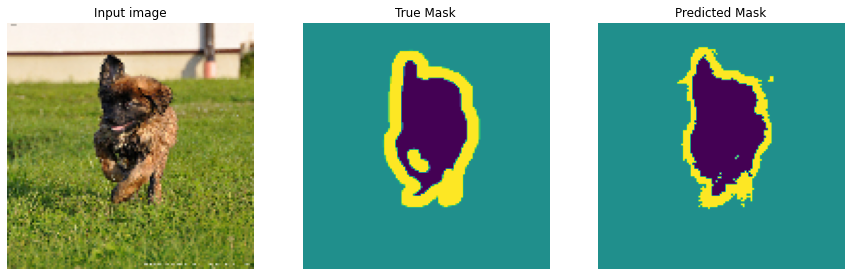

Sample prediction after epoch 1

Epoch 2/20
613/613 [==============================] - 15s 24ms/step - loss: 0.3176 - accuracy: 0.8709 - val_loss: 0.2797 - val_accuracy: 0.8874


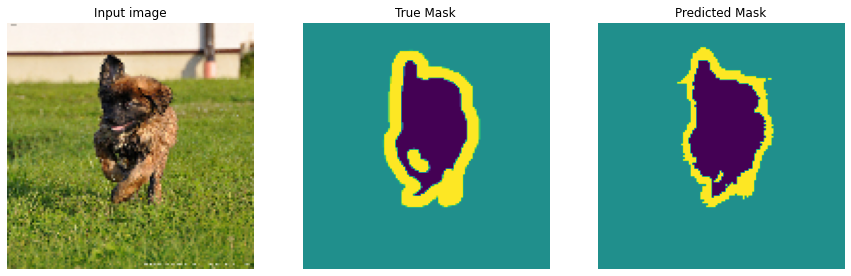

Sample prediction after epoch 2

Epoch 3/20
613/613 [==============================] - 15s 24ms/step - loss: 0.3002 - accuracy: 0.8777 - val_loss: 0.2911 - val_accuracy: 0.8799


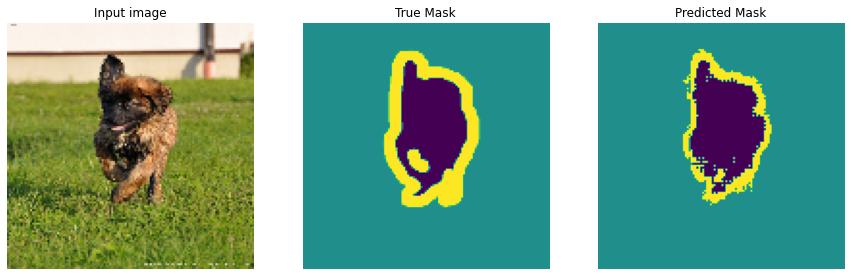

Sample prediction after epoch 3

Epoch 4/20
613/613 [==============================] - 15s 24ms/step - loss: 0.2923 - accuracy: 0.8804 - val_loss: 0.2757 - val_accuracy: 0.8896


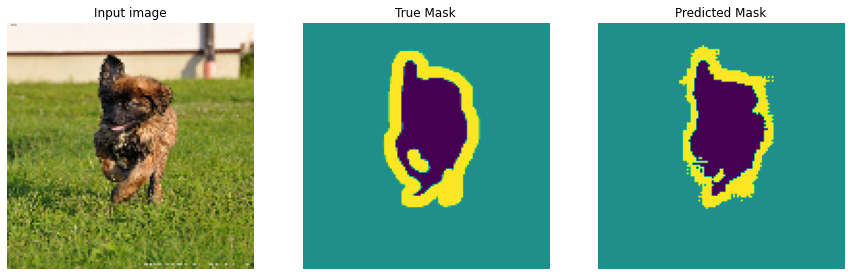

Sample prediction after epoch 4

Epoch 5/20
613/613 [==============================] - 15s 25ms/step - loss: 0.2850 - accuracy: 0.8827 - val_loss: 0.2727 - val_accuracy: 0.8905


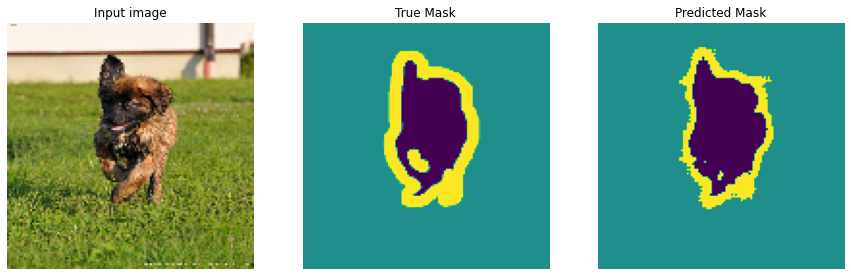

Sample prediction after epoch 5

Epoch 6/20
613/613 [==============================] - 16s 25ms/step - loss: 0.2788 - accuracy: 0.8851 - val_loss: 0.2726 - val_accuracy: 0.8880


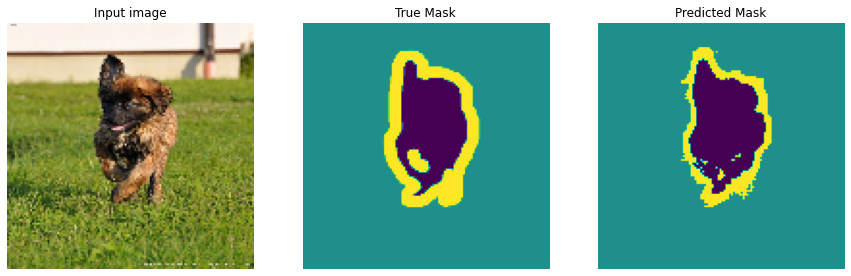

Sample prediction after epoch 6

Epoch 7/20
613/613 [==============================] - 15s 25ms/step - loss: 0.2711 - accuracy: 0.8877 - val_loss: 0.2926 - val_accuracy: 0.8803


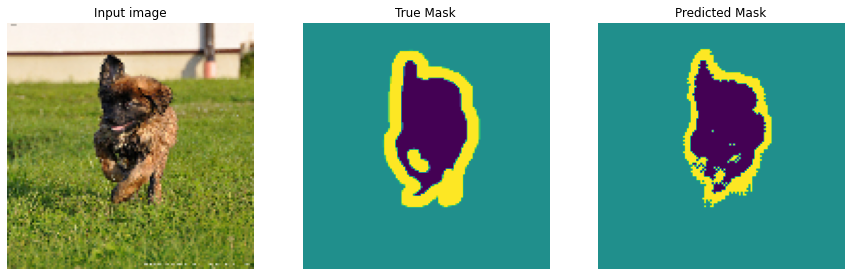

Sample prediction after epoch 7

Epoch 8/20
613/613 [==============================] - 16s 26ms/step - loss: 0.2663 - accuracy: 0.8892 - val_loss: 0.2720 - val_accuracy: 0.8900


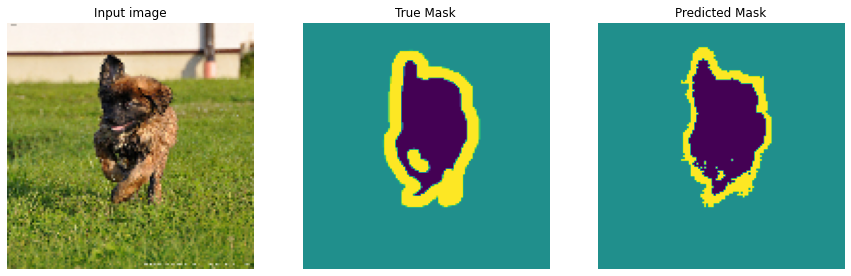

Sample prediction after epoch 8

Epoch 9/20
613/613 [==============================] - 16s 25ms/step - loss: 0.2628 - accuracy: 0.8903 - val_loss: 0.2689 - val_accuracy: 0.8921


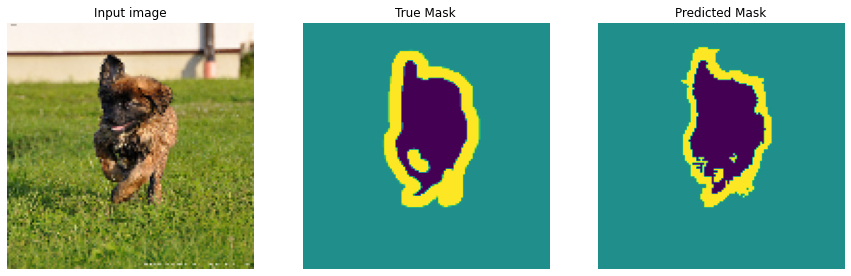

Sample prediction after epoch 9

Epoch 10/20
613/613 [==============================] - 15s 25ms/step - loss: 0.2583 - accuracy: 0.8920 - val_loss: 0.2680 - val_accuracy: 0.8933


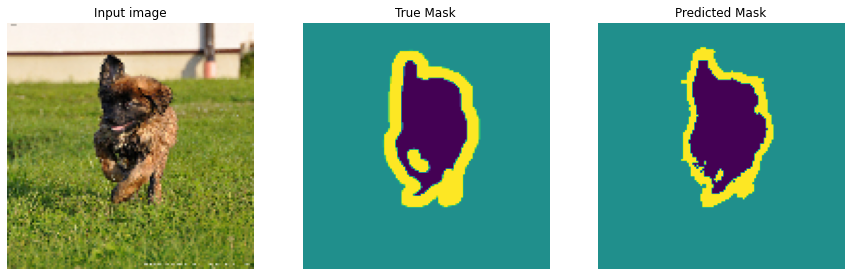

Sample prediction after epoch 10

Epoch 11/20
613/613 [==============================] - 16s 25ms/step - loss: 0.2524 - accuracy: 0.8941 - val_loss: 0.2652 - val_accuracy: 0.8946


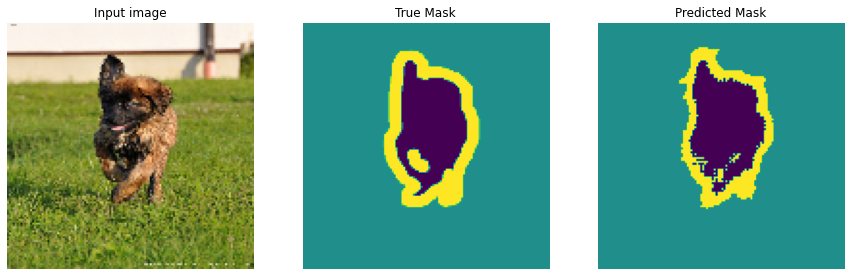

Sample prediction after epoch 11

Epoch 12/20
613/613 [==============================] - 16s 26ms/step - loss: 0.2522 - accuracy: 0.8943 - val_loss: 0.2673 - val_accuracy: 0.8937


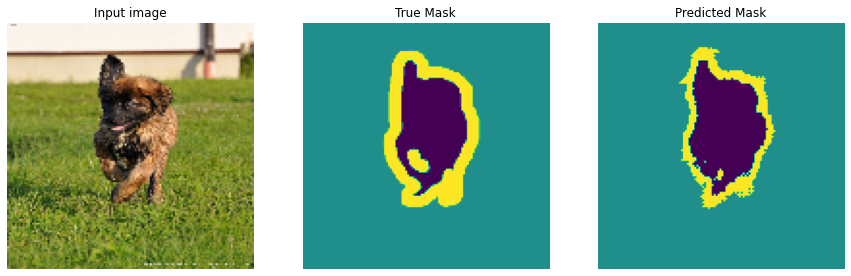

Sample prediction after epoch 12

Epoch 13/20
613/613 [==============================] - 16s 26ms/step - loss: 0.2465 - accuracy: 0.8961 - val_loss: 0.2681 - val_accuracy: 0.8941


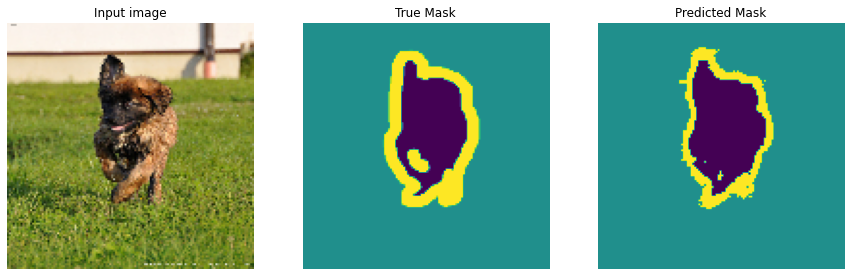

Sample prediction after epoch 13

Epoch 14/20
613/613 [==============================] - 16s 26ms/step - loss: 0.2412 - accuracy: 0.8976 - val_loss: 0.2644 - val_accuracy: 0.8950


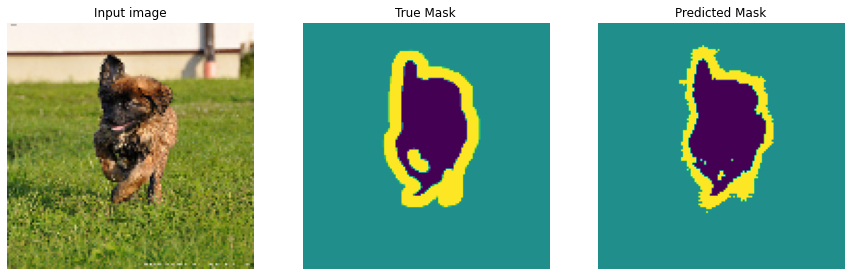

Sample prediction after epoch 14

Epoch 15/20
613/613 [==============================] - 16s 26ms/step - loss: 0.2381 - accuracy: 0.8989 - val_loss: 0.2622 - val_accuracy: 0.8965


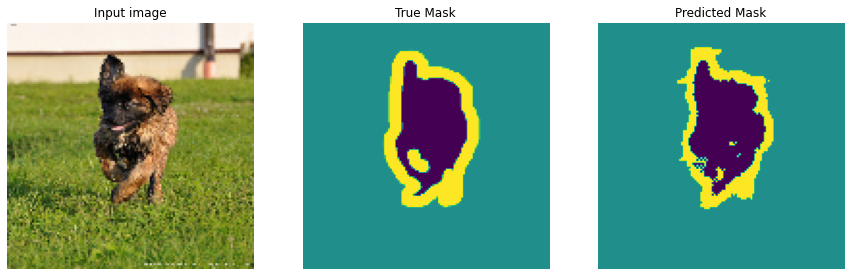

Sample prediction after epoch 15

Epoch 16/20
613/613 [==============================] - 17s 27ms/step - loss: 0.2360 - accuracy: 0.8995 - val_loss: 0.2701 - val_accuracy: 0.8949


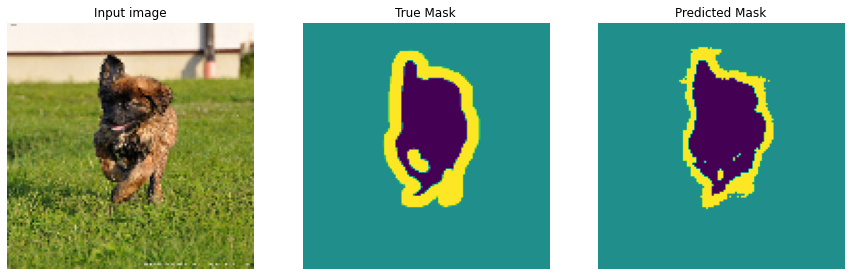

Sample prediction after epoch 16

Epoch 17/20
613/613 [==============================] - 16s 26ms/step - loss: 0.2314 - accuracy: 0.9011 - val_loss: 0.2731 - val_accuracy: 0.8943


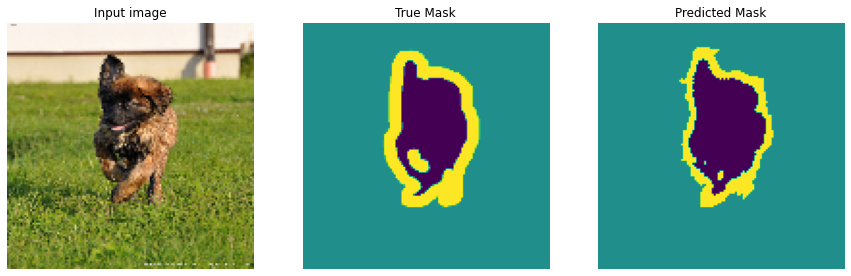

Sample prediction after epoch 17

Epoch 18/20
613/613 [==============================] - 16s 26ms/step - loss: 0.2291 - accuracy: 0.9019 - val_loss: 0.2707 - val_accuracy: 0.8947


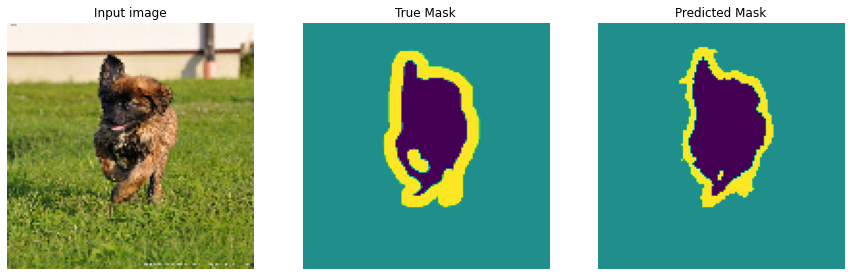

Sample prediction after epoch 18

Epoch 19/20
613/613 [==============================] - 17s 27ms/step - loss: 0.2252 - accuracy: 0.9034 - val_loss: 0.2684 - val_accuracy: 0.8971


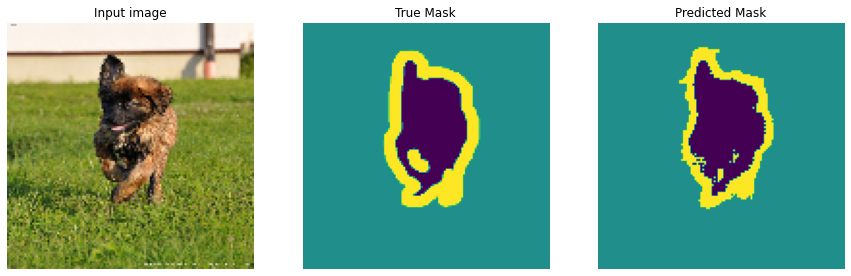

Sample prediction after epoch 19

Epoch 20/20
613/613 [==============================] - 17s 28ms/step - loss: 0.2220 - accuracy: 0.9044 - val_loss: 0.2828 - val_accuracy: 0.8908


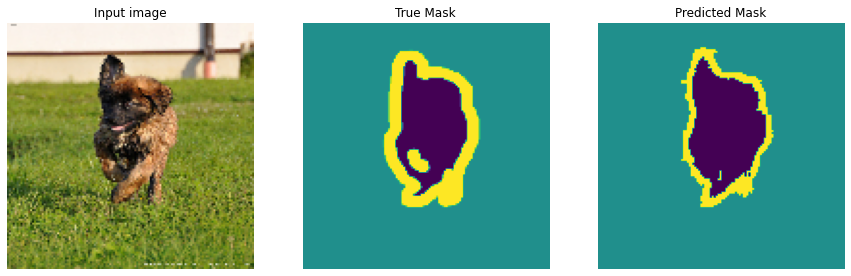

Sample prediction after epoch 20



In [40]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

##Model training history plot

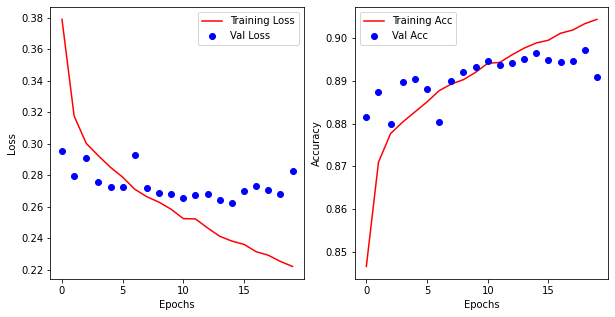

In [44]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = model_history.epoch

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'bo', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'bo', label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#Sample Predictions


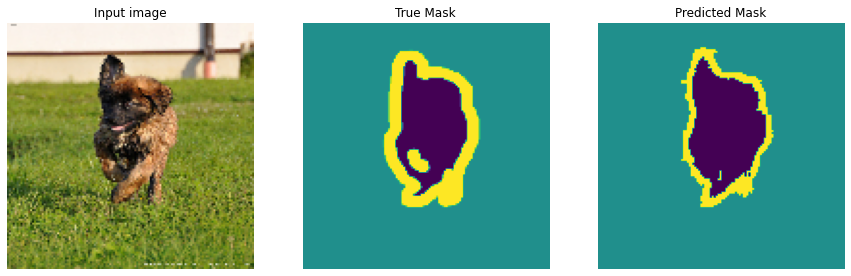

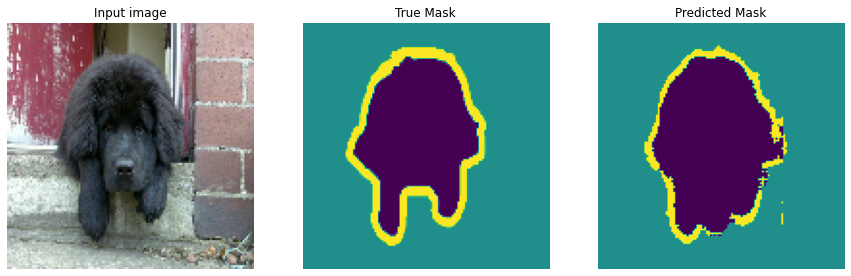

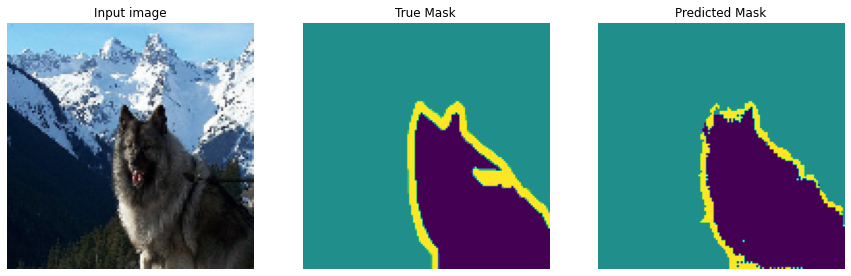

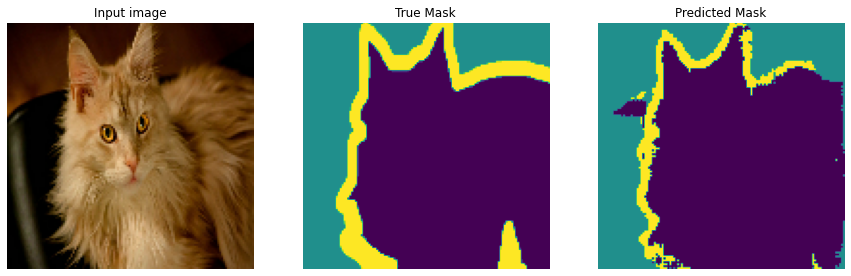

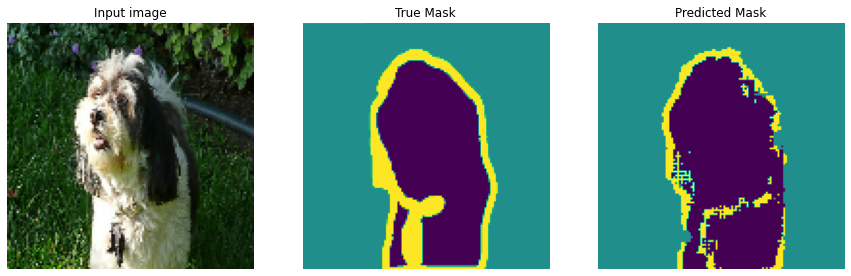

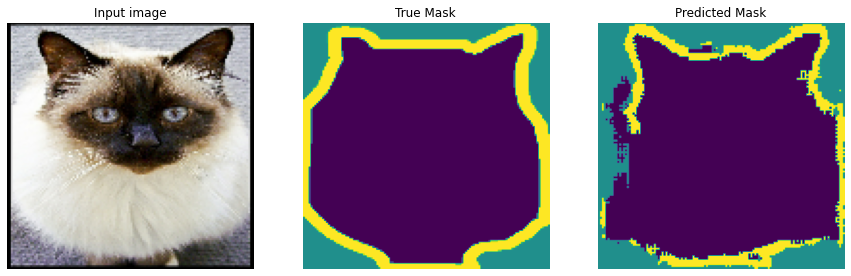

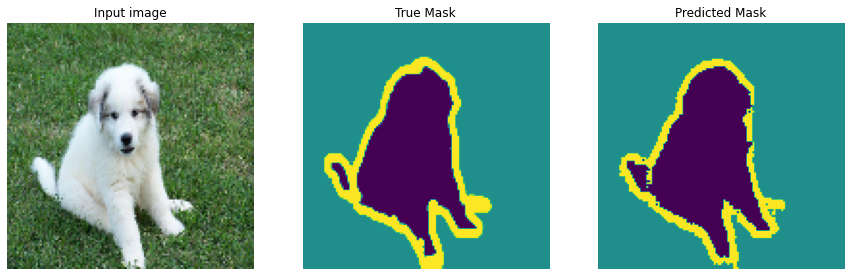

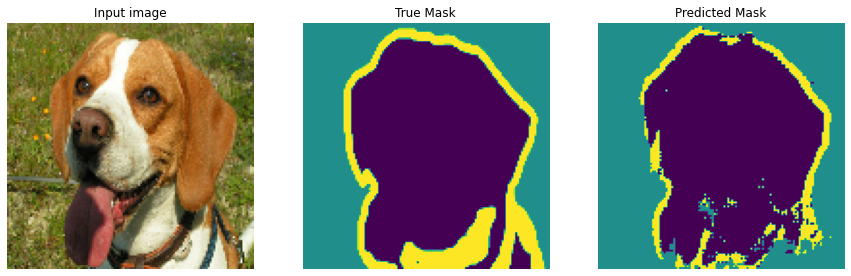

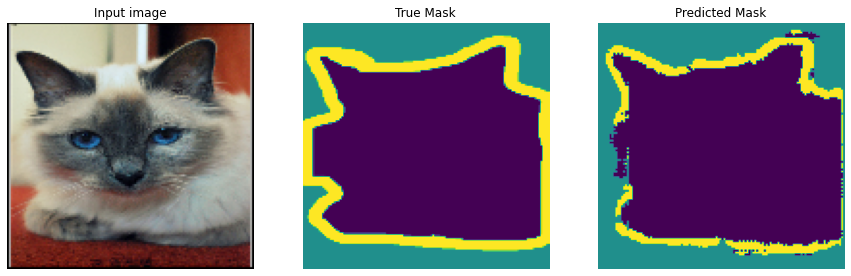

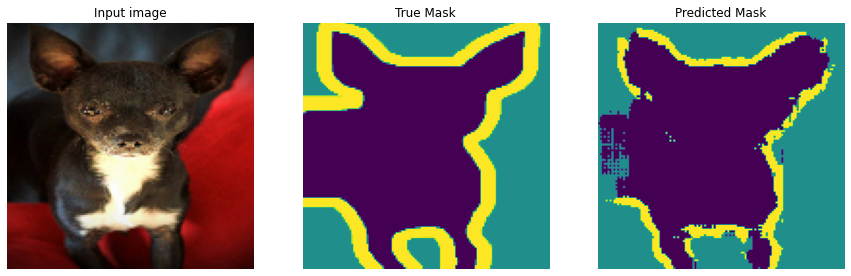

In [50]:
for image, mask in test_dataset.take(10):
    show_predictions(image,mask)

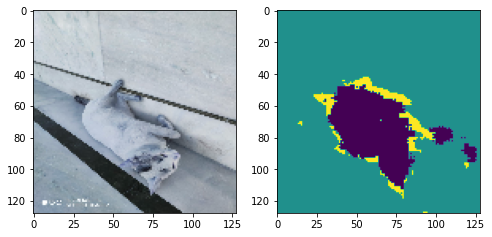

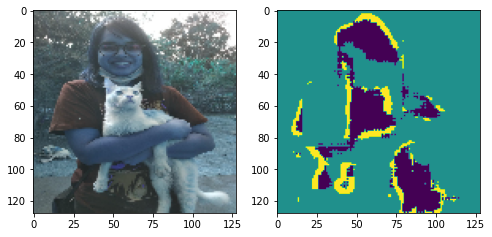

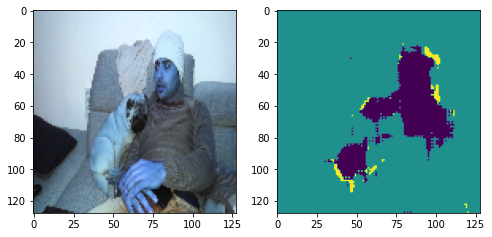

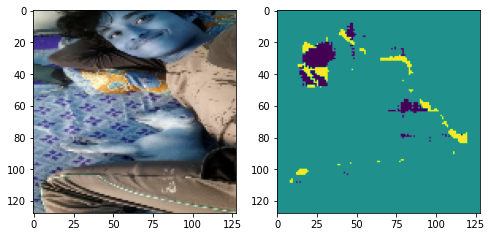

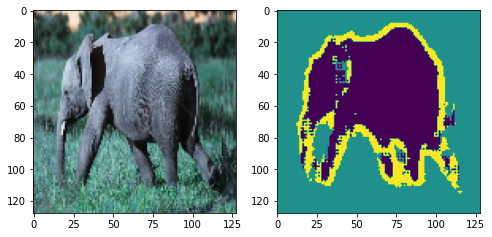

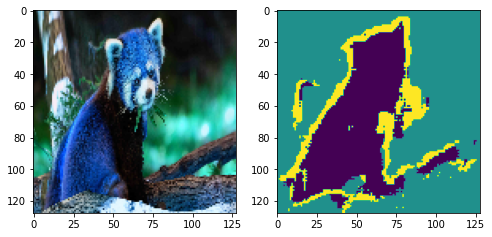

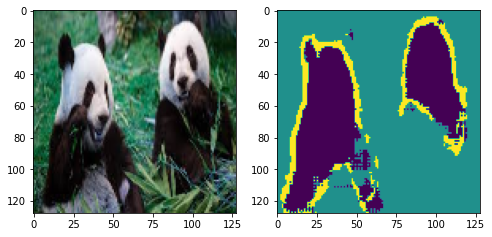

In [71]:
#Inferring on out-of-dataset images

import cv2
images = ['cat.jpeg',
          'cat_w_human.jpeg',
          'cuddle.jpeg',
          'dog_w_human.jpeg',
          'elephant.jpeg',
          'racoon.png',
          'panda.jpeg'
          ]

for image in images:
    image = tf.convert_to_tensor(cv2.imread(image), dtype=tf.float32)
    image = normalize(tf.image.resize(image, (128,128)))
    pred = model(image[tf.newaxis, ...])[0]
    pred = tf.argmax(pred,axis=-1)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(pred)
    plt.show()